Below is boilerplate items for each of these analysis notebooks.

In [1]:
DATA_FOLDER = 'data/fsm/'

In [2]:
from IPython.display import display, HTML
import numpy as np

Import my own custom handlers

In [3]:
import altair as alt
alt.renderers.enable('notebook')

from viz import visualize_seqs
from model_stats import ModelStats

results = ModelStats()

# Data - FSM

The data for fsm is based off of the below automaton.

![alt text](data/fsm/IrregularFSM.png "Title")

Read data

IMPORTANT: Adding 1 to each event so that the events start at 1.  This is important for when later using one-hot models and using 0 as a padding.

In [4]:
file_index = 1
events = {}
times = {}

for data_type in ['train', 'test']:
    with open(DATA_FOLDER + 'event-' + str(file_index) + '-' + data_type + '.txt') as f_events:
        events[data_type] = [[int(y) + 1 for y in x.split()] for x in f_events]
        
    with open(DATA_FOLDER + 'time-' + str(file_index) + '-' + data_type + '.txt') as f_times:
        times[data_type] = [[float(y) for y in x.split()] for x in f_times]

Compute deltas for times.

It seems that the general approach usually is to just use timestamps, but going to also compute deltas because maybe will want to use that to make things easier.

In [5]:
deltas = {}
for data_type in ['train', 'test']:
    deltas[data_type] = []
    for seq in times[data_type]:
        seq_deltas = []
        for i in range(1, len(seq)):
            seq_deltas.append(seq[i] - seq[i-1])
        deltas[data_type].append(seq_deltas)

# Models for Both

Errors for these models is RMSE:

https://en.wikipedia.org/wiki/Root-mean-square_deviation

# Helper Functions

In [6]:
def make_flat(arr):
    flattened = []
    for seq in arr:
        flattened += seq
        
    return flattened

In [7]:
def convert_flat(predictions, data_type):
    pred = []
    index = 0
    for s, seq in enumerate(events[data_type]):
        start_index = index
        index += len(seq) - 1
        pred.append(predictions[start_index:index])
        
    return pred

In [8]:
def convert_nn_seq(predictions, data_type):
    pred = []
    for s, seq in enumerate(events[data_type]):
        seq_len = len(seq) - 1
        pred.append(predictions[s][-seq_len:].tolist())
        
    return pred

In [9]:
from sklearn.metrics import mean_squared_error
import math

def compute_event_error(y_true, y_pred):
    num_error = 0
    total = 0
    for s, seq in enumerate(y_true):
        total += len(seq) - 1
        for e, event in enumerate(seq[1:]):
            if event != y_pred[s][e]:
                num_error += 1
                
    return (num_error / total) * 100

def compute_time_error(y_true, y_pred):
    y_true = make_flat(y_true)
    y_pred = make_flat(y_pred)
    
    return math.sqrt(mean_squared_error(y_true, y_pred))

def show_results(name, train_pred, test_pred):
    print('----')
    train_event_err = compute_event_error(events['train'], train_pred[0])
    train_time_err = compute_time_error(deltas['train'], train_pred[1])
    test_event_err = compute_event_error(events['test'], test_pred[0])
    test_time_err = compute_time_error(deltas['test'], test_pred[1])
    results.add_stat(name, {'train': train_event_err, 'test': test_event_err}, {'train': train_time_err, 'test': test_time_err})
    print('Train Error: ', train_event_err, '-', train_time_err)
    print('Test Error: ', test_event_err, '-', test_time_err)
    display(HTML('<h3>Train</h3>'))
    display(HTML(visualize_seqs(events['train'], train_pred[0], deltas['train'], train_pred[1])))
    display(HTML('<h3>Test</h3>'))
    display(HTML(visualize_seqs(events['test'], train_pred[0], deltas['test'], test_pred[1])))

In [10]:
def show_results_nn(name, train_preds, test_preds):
    # Convert event predictions
    train_preds[0] = np.argmax(train_preds[0], axis=2) + 1
    test_preds[0] = np.argmax(test_preds[0], axis=2) + 1
    
    train_preds[1] = np.squeeze(train_preds[1], axis=2)
    test_preds[1] = np.squeeze(test_preds[1], axis=2)
    
    for i in range(2):
        train_preds[i] = convert_nn_seq(train_preds[i], 'train')
        test_preds[i] = convert_nn_seq(test_preds[i], 'test')
        
    show_results(name, train_preds, test_preds)

# Baseline Predictor

Using methodology from https://github.com/dunan/NeuralPointProcess/blob/master/code/baselines/majority_predictor/time_mean_baseline.py

A scale is used there so adding a variable for that.

In [11]:
scale = 0.001

In [12]:
# Predict events
from collections import Counter

cnt = Counter()
for seq in events['train']:
    for event in seq:
        cnt[event] += 1

top = cnt.most_common(1)[0][0]
print('Most commom event is', top)

train_pred_events = [[top for event in seq[1:]] for seq in events['train']]
test_pred_events = [[top for event in seq[1:]] for seq in events['test']]


# Predict deltas
train_deltas = make_flat(deltas['train'])
train_deltas = np.asarray(train_deltas) * scale

mean_delta = np.mean(train_deltas)
print('Mean predictor using deltas', mean_delta)

train_pred_deltas = [[mean_delta for d in seq] for seq in deltas['train']]
test_pred_deltas = [[mean_delta for d in seq] for seq in deltas['test']]


# Show results
show_results('Majority', (train_pred_events, train_pred_deltas), (test_pred_events, test_pred_deltas))

Most commom event is 1
Mean predictor using deltas 0.0027380000000000004
----
Train Error:  100.0 - 2.9005196445885346
Test Error:  100.0 - 2.9128934921558667


# Structure Data

Need to structure the data into entire sequences for the approaches

Normalize deltas for the neural network approaches.  Could try alternate normalization techniques in the future.

In [13]:
# Get the min and max deltas
min_delta = 999999
max_delta = -1

for data_type in ['train', 'test']:
    for seq in deltas[data_type]:
        if min(seq) < min_delta:
            min_delta = min(seq)
            
        if max(seq) > max_delta:
            max_delta = max(seq)
            

print('Min delta', min_delta)
print('Max delta', max_delta)

deltas_temp = {}
# Normalize based on max, just going to ignore min and treat it like it was 0
for data_type in ['train', 'test']:
    deltas_temp[data_type] = [[d / max_delta for d in seq] for seq in deltas[data_type]]
    
# # Function to undo normalize
# def undo_norm_deltas(preds):
#     for data_type in ['train', 'test']:
    

Min delta 2.0
Max delta 5.0


In [14]:
x = {}
y = {}

for data_type in ['train', 'test']:
    x[data_type] = [[], []]
    y[data_type] = [[], []]
    
    # Events
    for seq in events[data_type]:
        x[data_type][0].append(seq[:-1])
        y[data_type][0].append(seq[1:])
        
    # Deltas
    for seq in deltas_temp[data_type]:
        x[data_type][1].append(seq[:-1])
        y[data_type][1].append(seq[1:])

    for i in range(2):
        x[data_type][i] = np.asarray(x[data_type][i])
        y[data_type][i] = np.asarray(y[data_type][i])

In [15]:
# Find the max user length
user_lengths = [len(seq) for seq in events['train']] + [len(seq) for seq in events['test']]
user_length_counts = {}
for length in user_lengths:
    if length not in user_length_counts:
        user_length_counts[length] = 0
        
    user_length_counts[length] += 1
user_lengths = list(set(user_lengths))
user_lengths = sorted(user_lengths, reverse=True)
max_user_length = max(user_lengths)

print('Max Seq Length', max_user_length)
# print(user_lengths)

Max Seq Length 5


Subtract one from x for events

In [16]:
for data_type in ['train', 'test']:
    x[data_type][0] = [[event - 1 for event in seq] for seq in x[data_type][0]]

In [17]:
# Pad sequences
from keras.preprocessing import sequence

for data_type in ['train', 'test']:
    for i in range(2):
        x[data_type][i] = sequence.pad_sequences(x[data_type][i], maxlen=max_user_length)
        y[data_type][i] = sequence.pad_sequences(y[data_type][i], maxlen=max_user_length)

D:\Users\fjd10\Anaconda3\envs\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


y variable needs to be one-hot for events.  (x will be made one-hot later for different models)

In [18]:
num_events = 22
one_hot = np.eye(num_events)
for data_type in ['train', 'test']:
    y[data_type][0] = [[one_hot[event-1] if event > 0 else np.zeros(num_events) for event in seq] for seq in y[data_type][0]]
    y[data_type][0] = np.asarray(y[data_type][0])

Add dimension to the end

In [19]:
x['train'][0] = np.expand_dims(x['train'][0], axis=2)
x['train'][1] = np.expand_dims(x['train'][1], axis=2)
y['train'][1] = np.expand_dims(y['train'][1], axis=2)

x['test'][0] = np.expand_dims(x['test'][0], axis=2)
x['test'][1] = np.expand_dims(x['test'][1], axis=2)
y['test'][1] = np.expand_dims(y['test'][1], axis=2)

# Neural Networks

We are going to try a bunch of different network configurations so let's import stuff that we'll need.

In [20]:
from keras.models import Sequential, Model
from keras import optimizers
from keras.layers import Input, Dense, TimeDistributed, Masking, SimpleRNN, Concatenate, RNN, LSTM

# TODO - Evaluate how categorical_accuracy works for metrics

In [37]:
input_events = Input(shape=(max_user_length, 1))
input_deltas = Input(shape=(max_user_length, 1))

inputs = Concatenate(axis=2)([input_events, input_deltas])
inputs = Masking(mask_value=0.)(inputs)

rnn = SimpleRNN(50, activation='tanh', return_sequences=True)(inputs)

output_events = TimeDistributed(Dense(num_events, activation='softmax'), name='events')(rnn)

output_deltas = TimeDistributed(Dense(15, activation='relu'))(rnn)
output_deltas = TimeDistributed(Dense(1, activation='sigmoid'), name='time')(output_deltas)

model = Model(inputs=[input_events, input_deltas], outputs=[output_events, output_deltas])

model.compile(loss=['categorical_crossentropy', 'mse'], optimizer='adam', metrics={'events': 'accuracy'})

model.fit(x['train'], y['train'], validation_data=(x['test'], y['test']), batch_size=50, epochs=5)

preds_train = model.predict(x['train'])
preds_test = model.predict(x['test'])

preds_train[0] += 1
preds_test[0] += 1

preds_train[1] *= max_delta
preds_test[1] *= max_delta

show_results_nn('RNN', preds_train, preds_test)

Train on 1000 samples, validate on 200 samples
Epoch 1/5
1000/1000 [==============================] - 2s 2ms/step - loss: 2.5586 - events_loss: 2.4389 - time_loss: 0.1197 - events_acc: 0.3593 - val_loss: 1.8434 - val_events_loss: 1.7891 - val_time_loss: 0.0544 - val_events_acc: 0.6667
Epoch 2/5
1000/1000 [==============================] - 0s 125us/step - loss: 1.5198 - events_loss: 1.4866 - time_loss: 0.0333 - events_acc: 0.7297 - val_loss: 1.2289 - val_events_loss: 1.2098 - val_time_loss: 0.0191 - val_events_acc: 0.8333
Epoch 3/5
1000/1000 [==============================] - 0s 107us/step - loss: 1.0497 - events_loss: 1.0362 - time_loss: 0.0135 - events_acc: 0.9323 - val_loss: 0.8804 - val_events_loss: 0.8716 - val_time_loss: 0.0088 - val_events_acc: 1.0000
Epoch 4/5
1000/1000 [==============================] - 0s 108us/step - loss: 0.7691 - events_loss: 0.7629 - time_loss: 0.0063 - events_acc: 1.0000 - val_loss: 0.6574 - val_events_loss: 0.6533 - val_time_loss: 0.0041 - val_events_acc

In [31]:
input_events = Input(shape=(max_user_length, 1))
input_deltas = Input(shape=(max_user_length, 1))

inputs = Concatenate(axis=2)([input_events, input_deltas])
inputs = Masking(mask_value=0.)(inputs)

rnn = LSTM(50, activation='tanh', return_sequences=True)(inputs)

output_events = TimeDistributed(Dense(num_events, activation='softmax'), name='events')(rnn)

output_deltas = TimeDistributed(Dense(15, activation='relu'))(rnn)
output_deltas = TimeDistributed(Dense(1, activation='sigmoid'), name='time')(output_deltas)

model = Model(inputs=[input_events, input_deltas], outputs=[output_events, output_deltas])

model.compile(loss=['categorical_crossentropy', 'mse'], optimizer='adam', metrics={'events': 'accuracy'})

model.fit(x['train'], y['train'], validation_data=(x['test'], y['test']), batch_size=100, epochs=50)

preds_train = model.predict(x['train'])
preds_test = model.predict(x['test'])

preds_train[1] *= max_delta
preds_test[1] *= max_delta

show_results_nn('LSTM', preds_train, preds_test)

Train on 1000 samples, validate on 200 samples
Epoch 1/50
1000/1000 [==============================] - 2s 2ms/step - loss: 3.2825 - events_loss: 3.0393 - time_loss: 0.2432 - events_acc: 0.2650 - val_loss: 3.1832 - val_events_loss: 2.9533 - val_time_loss: 0.2299 - val_events_acc: 0.3333
Epoch 2/50
1000/1000 [==============================] - 0s 133us/step - loss: 3.0962 - events_loss: 2.8780 - time_loss: 0.2182 - events_acc: 0.3637 - val_loss: 2.9831 - val_events_loss: 2.7800 - val_time_loss: 0.2031 - val_events_acc: 0.6667
Epoch 3/50
1000/1000 [==============================] - 0s 102us/step - loss: 2.8798 - events_loss: 2.6887 - time_loss: 0.1911 - events_acc: 0.6280 - val_loss: 2.7421 - val_events_loss: 2.5662 - val_time_loss: 0.1759 - val_events_acc: 0.5000
Epoch 4/50
1000/1000 [==============================] - 0s 93us/step - loss: 2.6129 - events_loss: 2.4520 - time_loss: 0.1610 - events_acc: 0.4973 - val_loss: 2.4424 - val_events_loss: 2.3014 - val_time_loss: 0.1410 - val_events_

1000/1000 [==============================] - 0s 91us/step - loss: 0.3145 - events_loss: 0.3141 - time_loss: 4.2836e-04 - events_acc: 0.8307 - val_loss: 0.3036 - val_events_loss: 0.3032 - val_time_loss: 4.0323e-04 - val_events_acc: 0.8333
Epoch 35/50
1000/1000 [==============================] - 0s 87us/step - loss: 0.3000 - events_loss: 0.2996 - time_loss: 3.9438e-04 - events_acc: 0.8307 - val_loss: 0.2895 - val_events_loss: 0.2891 - val_time_loss: 3.7242e-04 - val_events_acc: 0.8333
Epoch 36/50
1000/1000 [==============================] - 0s 83us/step - loss: 0.2860 - events_loss: 0.2857 - time_loss: 3.6527e-04 - events_acc: 0.8307 - val_loss: 0.2755 - val_events_loss: 0.2752 - val_time_loss: 3.4449e-04 - val_events_acc: 0.8333
Epoch 37/50
1000/1000 [==============================] - 0s 86us/step - loss: 0.2719 - events_loss: 0.2716 - time_loss: 3.3760e-04 - events_acc: 0.8307 - val_loss: 0.2620 - val_events_loss: 0.2616 - val_time_loss: 3.1971e-04 - val_events_acc: 0.8333
Epoch 38/50


## Phased-LSTM Model

In [32]:
from phasedlstmcell import PhasedLSTMCell

input_events = Input(shape=(max_user_length, 1))
input_deltas = Input(shape=(max_user_length, 1))

inputs = Concatenate(axis=2)([input_events, input_deltas])
inputs = Masking(mask_value=0.)(inputs)

cell = PhasedLSTMCell(50, activation='tanh')
rnn = RNN(cell, return_sequences=True)(inputs)

output_events = TimeDistributed(Dense(num_events, activation='softmax'), name='events')(rnn)

output_deltas = TimeDistributed(Dense(15, activation='relu'))(rnn)
output_deltas = TimeDistributed(Dense(1, activation='sigmoid'), name='time')(output_deltas)

model = Model(inputs=[input_events, input_deltas], outputs=[output_events, output_deltas])

model.compile(loss=['categorical_crossentropy', 'mse'], optimizer='adam', metrics={'events': 'accuracy'})

model.fit(x['train'], y['train'], validation_data=(x['test'], y['test']), batch_size=100, epochs=100)

preds_train = model.predict(x['train'])
preds_test = model.predict(x['test'])

preds_train[1] *= max_delta
preds_test[1] *= max_delta

show_results_nn('PhasedLSTM', preds_train, preds_test)

Train on 1000 samples, validate on 200 samples
Epoch 1/100
1000/1000 [==============================] - 2s 2ms/step - loss: 3.3258 - events_loss: 3.0792 - time_loss: 0.2466 - events_acc: 0.2667 - val_loss: 3.3100 - val_events_loss: 3.0682 - val_time_loss: 0.2418 - val_events_acc: 0.3333
Epoch 2/100
1000/1000 [==============================] - 0s 130us/step - loss: 3.2969 - events_loss: 3.0586 - time_loss: 0.2383 - events_acc: 0.3333 - val_loss: 3.2801 - val_events_loss: 3.0463 - val_time_loss: 0.2338 - val_events_acc: 0.3333
Epoch 3/100
1000/1000 [==============================] - 0s 123us/step - loss: 3.2650 - events_loss: 3.0352 - time_loss: 0.2298 - events_acc: 0.3333 - val_loss: 3.2459 - val_events_loss: 3.0212 - val_time_loss: 0.2247 - val_events_acc: 0.3333
Epoch 4/100
1000/1000 [==============================] - 0s 135us/step - loss: 3.2291 - events_loss: 3.0089 - time_loss: 0.2202 - events_acc: 0.3333 - val_loss: 3.2080 - val_events_loss: 2.9935 - val_time_loss: 0.2145 - val_ev

1000/1000 [==============================] - 0s 115us/step - loss: 1.3526 - events_loss: 1.3503 - time_loss: 0.0023 - events_acc: 0.4973 - val_loss: 1.3400 - val_events_loss: 1.3378 - val_time_loss: 0.0022 - val_events_acc: 0.5000
Epoch 35/100
1000/1000 [==============================] - 0s 121us/step - loss: 1.3404 - events_loss: 1.3383 - time_loss: 0.0021 - events_acc: 0.4973 - val_loss: 1.3290 - val_events_loss: 1.3270 - val_time_loss: 0.0020 - val_events_acc: 0.5000
Epoch 36/100
1000/1000 [==============================] - 0s 115us/step - loss: 1.3298 - events_loss: 1.3279 - time_loss: 0.0019 - events_acc: 0.4973 - val_loss: 1.3167 - val_events_loss: 1.3149 - val_time_loss: 0.0018 - val_events_acc: 0.5000
Epoch 37/100
1000/1000 [==============================] - 0s 115us/step - loss: 1.3191 - events_loss: 1.3173 - time_loss: 0.0018 - events_acc: 0.4973 - val_loss: 1.3076 - val_events_loss: 1.3059 - val_time_loss: 0.0017 - val_events_acc: 0.5000
Epoch 38/100
1000/1000 [=============

Epoch 67/100
1000/1000 [==============================] - 0s 118us/step - loss: 1.1197 - events_loss: 1.1193 - time_loss: 3.1059e-04 - events_acc: 0.6613 - val_loss: 1.1119 - val_events_loss: 1.1116 - val_time_loss: 3.0024e-04 - val_events_acc: 0.6667
Epoch 68/100
1000/1000 [==============================] - 0s 111us/step - loss: 1.1127 - events_loss: 1.1124 - time_loss: 2.9905e-04 - events_acc: 0.6453 - val_loss: 1.1044 - val_events_loss: 1.1041 - val_time_loss: 2.8553e-04 - val_events_acc: 0.6667
Epoch 69/100
1000/1000 [==============================] - 0s 109us/step - loss: 1.1055 - events_loss: 1.1052 - time_loss: 2.8543e-04 - events_acc: 0.6613 - val_loss: 1.0969 - val_events_loss: 1.0966 - val_time_loss: 2.7229e-04 - val_events_acc: 0.6667
Epoch 70/100
1000/1000 [==============================] - 0s 111us/step - loss: 1.0982 - events_loss: 1.0979 - time_loss: 2.7435e-04 - events_acc: 0.6613 - val_loss: 1.0906 - val_events_loss: 1.0903 - val_time_loss: 2.6784e-04 - val_events_acc:

1000/1000 [==============================] - 0s 106us/step - loss: 0.8972 - events_loss: 0.8971 - time_loss: 1.1954e-04 - events_acc: 0.6613 - val_loss: 0.8900 - val_events_loss: 0.8899 - val_time_loss: 1.1596e-04 - val_events_acc: 0.6667
Epoch 100/100
1000/1000 [==============================] - 0s 107us/step - loss: 0.8918 - events_loss: 0.8917 - time_loss: 1.1733e-04 - events_acc: 0.6613 - val_loss: 0.8845 - val_events_loss: 0.8843 - val_time_loss: 1.1380e-04 - val_events_acc: 0.6667
----
Train Error:  50.4 - 2.6756552722802738
Test Error:  50.0 - 2.687559008206453


# Model Stats

## Event Error

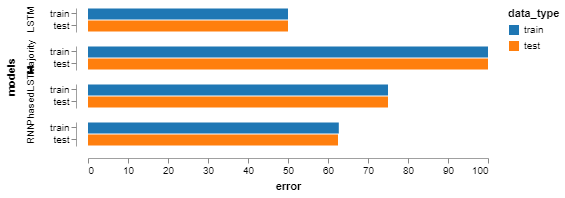

In [24]:
results.grouped_bar('event')

### Train

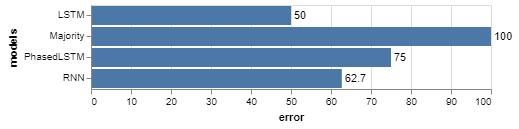

In [25]:
results.graph_results('event', 'train')

### Test

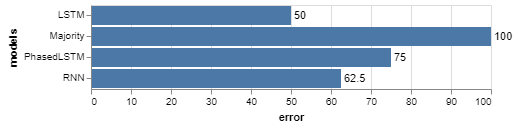

In [26]:
results.graph_results('event', 'test')

## Time Error

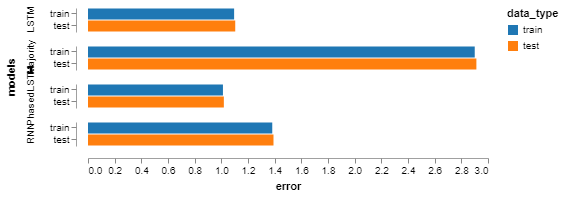

In [27]:
results.grouped_bar('time')

### Train

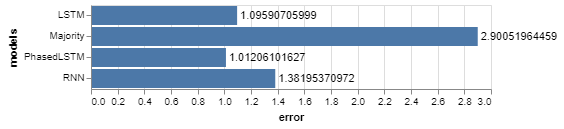

In [28]:
results.graph_results('time', 'train')

### Test

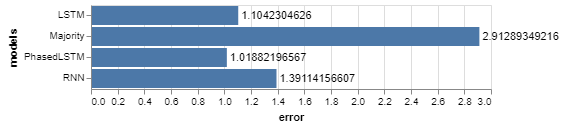

In [29]:
results.graph_results('time', 'test')